In [10]:
import csv
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from datetime import datetime

In [2]:
initial = pd.read_csv('C:/users/rustym/documents/github/patchseq_gdoc_analysis/patch_seq_log_mouse.csv')

In [3]:
ps = initial[["Date", "Post patch?", "Post patch pipette R", "PCR cycles", "Time spent extracting cytosol", "Time spent retracting pipette", 
              "patch duration", "Resolution index", "SM_QC_PF", "Bad dates"]]
ps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7927 entries, 0 to 7926
Data columns (total 10 columns):
Date                             7927 non-null int64
Post patch?                      5047 non-null object
Post patch pipette R             493 non-null float64
PCR cycles                       7489 non-null float64
Time spent extracting cytosol    5248 non-null object
Time spent retracting pipette    493 non-null float64
patch duration                   5187 non-null object
Resolution index                 2265 non-null float64
SM_QC_PF                         6870 non-null object
Bad dates                        1269 non-null object
dtypes: float64(4), int64(1), object(5)
memory usage: 619.4+ KB


In [4]:
ps["SM_QC_PF"] = ps["SM_QC_PF"].astype("category")
ps["PCR cycles"] = ps["PCR cycles"].astype("category")
ps["Bad dates"] = ps["Bad dates"].astype("category")

ps = ps[ps["PCR cycles"] == 21]
ps = ps[ps["SM_QC_PF"] != "cnt"]
ps = ps[ps["Bad dates"] != "x"]
ps = ps.drop("Bad dates", 1)

#ps = ps[ps[">400"] < 8000]
#ps = ps[ps['Time spent extracting cytosol'] <= 10]

ps["Date"] = pd.to_datetime(ps["Date"], format = '%y%m%d')
ps["Time spent extracting cytosol"] = pd.to_numeric(ps["Time spent extracting cytosol"].str.replace(' ',''), errors ='force')
#ps["Time spent retracting pipette"] = pd.to_numeric(ps["Time spent retracting pipette"].str.replace(' ',''), errors ='force')
ps["patch duration"] = pd.to_numeric(ps["patch duration"].str.replace(' ',''), errors ='force')
#ps["Resolution index"] = pd.to_numeric(ps["Resolution index"].str.replace(' ',''), errors ='force')

ps['Time spent retracting pipette'] = ps['Time spent retracting pipette'].fillna(0)
ps.dropna(subset = ["Time spent extracting cytosol", "patch duration", "Resolution index"], inplace = True)

ps.head()

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

,Date,Post patch?,Post patch pipette R,PCR cycles,Time spent extracting cytosol,Time spent retracting pipette,patch duration,Resolution index,SM_QC_PF
4969,2017-04-19,Outside-Out,NaN,21.0,1.666667,0.0,6.566667,0.923406,pass
4971,2017-04-19,Nucleated,NaN,21.0,2.350000,0.0,7.416667,0.000000,pass
4972,2017-04-19,Outside-Out,NaN,21.0,2.216667,0.0,4.166667,0.322631,pass
4973,2017-04-19,Nucleated,NaN,21.0,2.183333,0.0,9.466667,0.322631,pass
4974,2017-04-19,No-Seal,NaN,21.0,1.883333,0.0,6.700000,0.000000,pass


In [5]:
ps['recording duration'] = ps['patch duration'] - ps['Time spent extracting cytosol'] - ps['Time spent retracting pipette']
ps.head()

,Date,Post patch?,Post patch pipette R,PCR cycles,Time spent extracting cytosol,Time spent retracting pipette,patch duration,Resolution index,SM_QC_PF,recording duration
4969,2017-04-19,Outside-Out,NaN,21.0,1.666667,0.0,6.566667,0.923406,pass,4.900000
4971,2017-04-19,Nucleated,NaN,21.0,2.350000,0.0,7.416667,0.000000,pass,5.066667
4972,2017-04-19,Outside-Out,NaN,21.0,2.216667,0.0,4.166667,0.322631,pass,1.950000
4973,2017-04-19,Nucleated,NaN,21.0,2.183333,0.0,9.466667,0.322631,pass,7.283333
4974,2017-04-19,No-Seal,NaN,21.0,1.883333,0.0,6.700000,0.000000,pass,4.816667


In [6]:
def nucleated(x):
    nucleus = x[(x["Post patch?"] == "Nucleated") | (((x["Post patch?"] == "nucleus_visible") | (x["Post patch?"] == "nucleus_present")) & (x["Post patch pipette R"] >= 500))]
    return nucleus

def partial_nucleated(y):
    partial = y[(y["Post patch?"] == 'Partial-Nucleus') | (((y['Post patch?'] == 'nucleus_present') | (y['Post patch?'] == 'nucleus_visible')) & (y["Post patch pipette R"] <= 499))]
    return partial

def outside_out(z):
    outside = z[(z["Post patch?"] == 'Outside-Out') | (((z['Post patch?'] == 'nucleus_absent') | (z['Post patch?'] == 'no_nuclues_visible')) & (z['Post patch pipette R'] >= 500))]
    return outside

def no_seal(w): 
    no = w[(w["Post patch?"] == 'No-Seal') | (((w['Post patch?'] == 'nucleus_absent') | (w['Post patch?'] == 'no_nucleus_visible')) & (w['Post patch pipette R'] <= 499))]
    return no
    
def entire_cell(v):
    entire = v[(v["Post patch?"] == 'Entire-Cell') | (v['Post patch?'] == 'entire_cell')]
    return entire

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

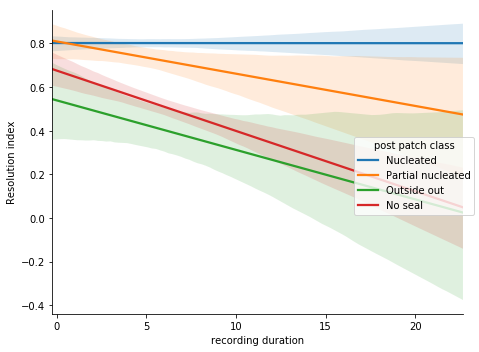

In [16]:
oo = outside_out(ps)
oo['post patch class'] = 'Outside out'
nu = nucleated(ps)
nu['post patch class'] = 'Nucleated'
ns = no_seal(ps)
ns['post patch class'] = 'No seal'
pn = partial_nucleated(ps)
pn['post patch class'] = 'Partial nucleated'
#ec = entire_cell(ps)
#ec['post patch class'] = 'Entire cell'

frames = (nu, pn, oo, ns)
ps = pd.concat(frames)
ps.head()

sns.lmplot(x='recording duration', y='Resolution index', data=ps, hue='post patch class', scatter=False)
plt.tight_layout()

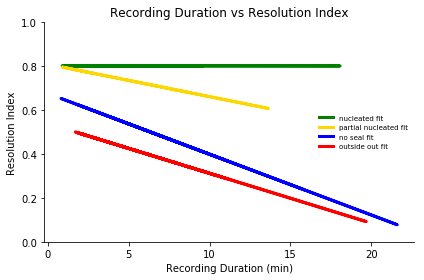

In [8]:
oo = outside_out(ps)
nu = nucleated(ps)
ns = no_seal(ps)
pn = partial_nucleated(ps)
ec = entire_cell(ps)

x1 = oo["recording duration"]
y1 = oo["Resolution index"]
x2 = nu["recording duration"]
y2 = nu["Resolution index"]
x3 = ns["recording duration"]
y3 = ns["Resolution index"]
x4 = pn["recording duration"]
y4 = pn["Resolution index"]

fig,ax = plt.subplots(1)
axes = plt.gca()
axes.set_ylim([0,1.0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Recording Duration vs Resolution Index')
plt.xlabel('Recording Duration (min)')
plt.ylabel('Resolution Index')

def make_scatter(x,y,c,m,l):
    ax.scatter(x,y,s=30,c=c,marker=m, label=l)
def make_fits(x,y,c,n):    
    z = np.polyfit(x,y,1)
    p = np.poly1d(z)
    ax.plot(x,p(x),c=c,label=n, linewidth=3)
    
#make_scatter(x1,y1,"white","s","outside out")
#make_scatter(x2,y2,"white","o","nucleated")
#make_scatter(x3,y3,"white","p","no seal")
#make_scatter(x4,y4,"white","v","partial nucleus")     

#make_scatter(x1,y1,"lightsalmon","s","outside out")
#make_scatter(x2,y2,"lime","o","nucleated")
#make_scatter(x3,y3,"cornflowerblue","p","no seal")
#make_scatter(x4,y4,"yellow","v","partial nucleus")    

make_fits(x1,y1,'r','outside out fit')
make_fits(x2,y2,'g','nucleated fit')
make_fits(x3,y3,'b','no seal fit')
make_fits(x4,y4,'gold','partial nucleated fit')

handles,labels = ax.get_legend_handles_labels()

handles = [handles[1],handles[3],handles[2],handles[0]]
labels = [labels[1],labels[3],labels[2],labels[0]]

ax.legend(handles,labels,scatterpoints=1,loc='center right',ncol=1,fontsize=7,frameon=False)
plt.tight_layout()
plt.savefig('recording_duration_vs_resolution_index.png',dpi=300)

oo = outside_out(ps)
nu = nucleated(ps)
ns = no_seal(ps)
pn = partial_nucleated(ps)
ec = entire_cell(ps)

x1 = oo["recording duration"]
y1 = oo["Resolution index"]
x2 = nu["recording duration"]
y2 = nu["Resolution index"]
x3 = ns["recording duration"]
y3 = ns["Resolution index"]
x4 = pn["recording duration"]
y4 = pn["Resolution index"]

fig,ax = plt.subplots(1)

plt.title('Recording Duration vs Resolution Index')
plt.xlabel('Recording Duration (min)')
plt.ylabel('Resolution Index')

def make_plots(x,y,c,m,l,n):
    ax.scatter(x,y,s=30,c=c,marker=m, edgecolor='black', label=l)
    z = np.polyfit(x,y,1)
    p = np.poly1d(z)
    ax.plot(x,p(x),c=c,label=n,path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
    
make_plots(x1,y1,"r","s","outside out","outside out fit")
make_plots(x2,y2,"g","o","nucleated","nucleated fit")
make_plots(x3,y3,"b","p","no seal","no seal fit")
make_plots(x4,y4,"y","v","partial nucleus","partial nucleus fit")    

handles,labels = ax.get_legend_handles_labels()

handles = [handles[4],handles[0],handles[5],handles[1],handles[6],handles[2],handles[7],handles[3]]
labels = [labels[4],labels[0],labels[5],labels[1],labels[6],labels[2],labels[7],labels[3]]

ax.legend(handles,labels,scatterpoints=1,loc='upper right',ncol=1,fontsize=7,frameon=False)
plt.tight_layout()
plt.savefig('recording_duration_vs_resolution_index.png',dpi=300)